# 02. PyTorch Computer Vision

https://www.learnpytorch.io/03_pytorch_computer_vision/

## Table of Contents

- [All Links in Document](#links)
- [PyTorch Computer Vision](#compvis)
- [Loading and Preparing Data](#loadprep)
- [Building a Model](#buildmodel)
- [Training a Model](#trainmodel)
- [Convolutional Neural Networks](#convnet)
- [Evaluation](#eval)
- [Saving and Loading](#saveload)

## All Links in Document <a name="links"></a>

- https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
- https://github.com/zalandoresearch/fashion-mnist
- https://pytorch.org/vision/stable/datasets
- https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST
- https://pytorch.org/docs/stable/generated/torch.randint
- https://pytorch.org/docs/stable/data
- https://pytorch.org/docs/stable/generated/torch.nn.Flatten
- https://poloclub.github.io/cnn-explainer
- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d
- https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d
- https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html
- https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix
- https://pytorch.org/tutorials/beginner/saving_loading_models
- https://pytorch.org/docs/stable/generated/torch.isclose

## PyTorch Computer Vision <a name="compvis" />

In [1]:
# Imports
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, ConfusionMatrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

# Helper functions from helper_functions.py
from helper_functions import plot_predictions, plot_decision_boundary

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu117
0.14.1+cu117


What exactly is Computer Vision? The term computer itself relates to how a neural network is going to "look" at an image. From there, it's possible to come up with all kinds of tasks, some of which have been handled in the previous chapters. It's possible to perform binary classification and multiclass classification. Where the examples in the previous chapters have focused on finding boundaries and classifying clusters of data points on a coordinate frame, computer vision will be able to classify objects or things in images instead. Object detection is also possible, where a model is focused on finding a certain thing in an image. A new topic is segmentation, which is is used to "focus" on certain things in an image, such as a specific person out of a group of people. Another obvious example are Tesla's self-driving cars, which require computer vision to parse the surrounding world in order to make the right decisions.

<img src="images/03_computer_vision.png" />

The typical input of such a computer vision program are of course images. These are usually split up into various colour channels, typically Red, Green, and Blue (RGB). Through numerical encoding are these values transformed into tensors containing normalized pixel values. After the model performs its tasks, output is given in numerical values again, which correlate to previously specified classes. Output may need a sigmoid or softmax function to make the results legible.

<img src="images/03_computer_vision_input_output.png" />

Note that that workflow is extremely similar to other examples handled in the previous chapters thus far.

Input for this kind of model contains various important bits of information. These are:

- Batch size / Number of images (N)
- Height (H)
- Width (W)
- Colour channels (C)

The order in which these are supplied depends on the library and language that is being used. There are two different orders, known as **NHWC** (colour channel last) and **NCHW** (colour channel first). The position of the batch size (N) remains unchanged. Within the remaining section of the abbreviation, the colour channels (C) then appear in front of the Height and Width (HW) or after it.

<img src="images/03_input_order.png" />

Note: PyTorch defaults to using colour channels first (**NCHW**) for its memory format!

Computer vision has close ties with Convolutional Neural Networks (CNN) due to them being very good at recognizing patterns in images. But what exactly is a CNN? Simply put, a CNN is a Deep Learning algorithm that can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other.

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

<img src="images/03_cnn_architecture.png" />

A typical (simple but not set in stone) architecture of a CNN can be seen above. Many components are familiar already, such as the `nn.ReLU()`, `torch.sigmoid()`, and `torch.softmax()` functions. There will naturally be some new architectural components to explore as well.

## Loading and Preparing Data  <a name="loadprep"></a>

Aside from the basic PyTorch library, there is a specific extra library to use for computer vision problems. Aptly named, this library is called `torchvision`. Within are various modules, data types, and functions that will come in handy for computer vision purposes. Some of these are:

- `torchvision.datasets`: Get existing datasets and data loading functions for computer vision
- `torchvision.models`: Get pretrained computer vision models that you can leverage for your own problems
- `torchvision.transforms`: Contains functions for manipulating your vision data (images) to be suitable for use with an ML model
- `torch.utils.data.Dataset`: Base dataset class for PyTorch
- `torch.utils.data.DataLoader`: Creates a Python iterable over a dataset

As `torchvision.datasets` suggests, there are many buily-in datasets to use for practice and experimentation. One such dataset is FashionMNIST: a play on the original MNIST dataset containing greyscale, hand-drawn images of the numbers 0 to 9, but with articles of clothing instead. This dataset can be found on the GitHub repository of the creator (https://github.com/zalandoresearch/fashion-mnist), but it's also available through `torchvision.datasets` by default. A comprehensive list of all available datasets can be found here: https://pytorch.org/vision/stable/datasets

Torchvision FashionMNIST docs: https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST

In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

The various function arguments have the following meanings:

- `root`: Defines where to download the data to (if necessary)
- `train`: A boolean to determine if training or testing data should be downloaded
- `download`: Whether to download the data or not, if the data already exists then it is not downloaded again
- `transform`: A function that accepts an image and returns a transformed version, used to transform into tensors
- `target_transform`: An optional function/transform that takes in the target and transforms it

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [6]:
# Checking the classes in the training data
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# Checking the classes and corresponding indices in the training data
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
# All the labels of the training data
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
print(f"Image Shape: {image.shape} > [Colour Channels, Height, Width]")
print(f"Image Label: {label} > {class_names[label]}")

Image Shape: torch.Size([1, 28, 28]) > [Colour Channels, Height, Width]
Image Label: 9 > Ankle boot


The shape of the image contains the following information:

- Colour channels: 1
- Height: 28
- Width: 28

There is only 1 colour channel as the images are greyscale. There are no RGB values available. The label of 9 corresponds to "Ankle boot".

Image Shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9: Ankle boot')

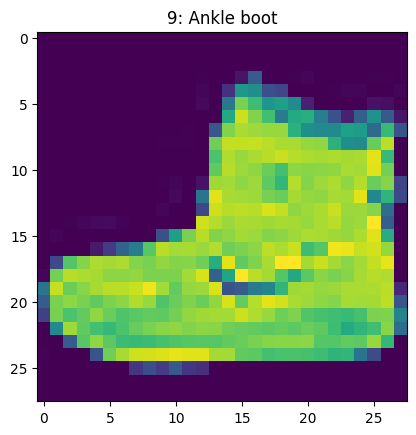

In [10]:
# Matplotlib accepts only height and width, or colour channels last
# The colour channels dimensions can be squeezed away in this case
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(f"{label}: {class_names[label]}")

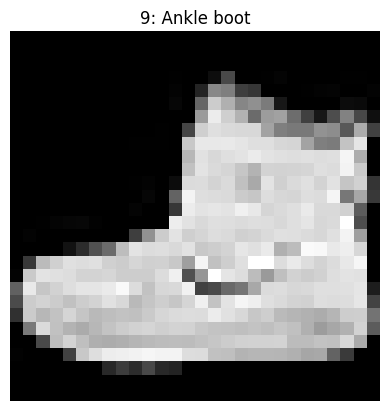

In [11]:
# Use the cmap argument to show greyscale
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"{label}: {class_names[label]}")
plt.axis(False);

Docs of `torch.randint`: https://pytorch.org/docs/stable/generated/torch.randint

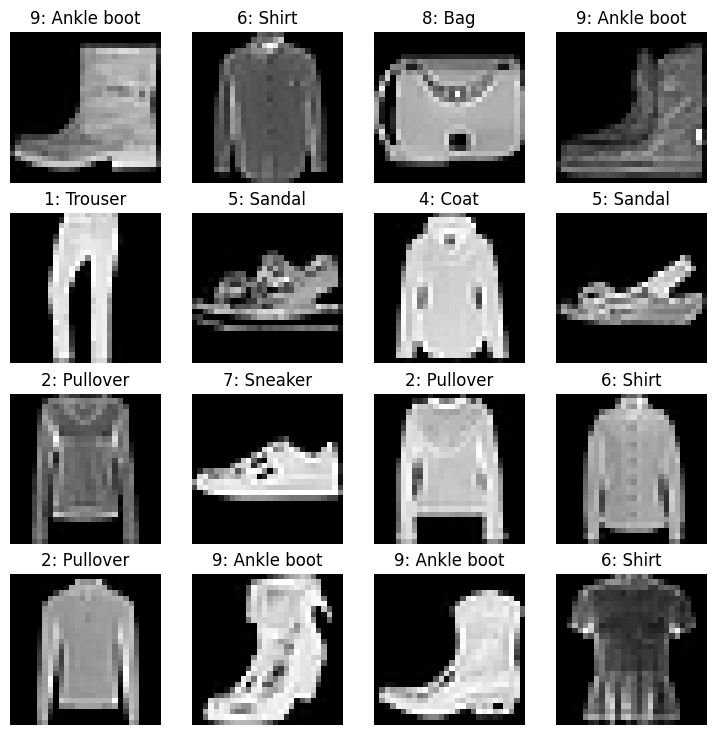

In [12]:
# Plotting a bunch of random images
# Grabbing random indices with torch.randint
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"{label}: {class_names[label]}")
    plt.axis(False)

In [13]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

Right now, the datasets exist in the form of PyTorch datasets. To use them for any upcoming models, it's necessary to use the aforementioned `torch.utils.data.DataLoader` to convert them to Python iterables. More specifically, it's important to divide the data into small batches. There are several reasons why this is important:

- It's computationally efficient
- The Neural Network has more opportunities to update gradients in an epoch

It may not be possible to store all 60,000 images into memory (or even more in other scenarios) at once, thus makes it computationally efficient to use batches. In addition, if all 60,000 images were to be used at once every epoch, it would mean that the gradients are updated only once every epoch. Utilizing batches will allow for more gradient updates, more specifically once after every X images, where X is the batch size. A very common batch size to use is 32. This behaviour was already seen in Stochastic Gradient Descent in the previous chapters, which creates batches automatically.

Docs of `torch.utils.data.DataLoader` and more: https://pytorch.org/docs/stable/data

In [14]:
# The model will never see the test dataset during training, shuffle is not necessary
# Keeping the same order for the test data may make evaluation easier to perform
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [15]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x17a36bdc130>,
 <torch.utils.data.dataloader.DataLoader at 0x17a36bdc070>)

In [16]:
print(f"Train DataLoader Batches: {len(train_dataloader)}") 
print(f"Train DataLoader Batches: {len(test_dataloader)}")

Train DataLoader Batches: 1875
Train DataLoader Batches: 313


In [17]:
# Grabbing a batch using Python iterable
batch_features, batch_labels = next(iter(train_dataloader))
batch_features.shape, batch_labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

The shape of this batch's contents contains the following information:

- Batch size: 32
- Colour channels: 1
- Height: 28
- Width: 28

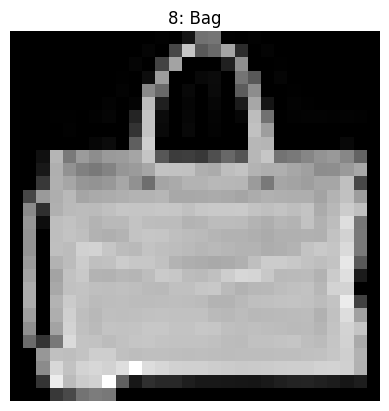

In [18]:
# Showing a random sample from this batch
random_idx = torch.randint(0, len(batch_features), size=[1]).item()
img, label = batch_features[random_idx], batch_labels[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"{label}: {class_names[label]}")
plt.axis(False);

## Building a Model <a name="buildmodel" />

Before creating a fancy model that's perfectly suited for this specific task, it's first important to build a baseline model which can be improved over time. A new layer to introduce here is the flatten layer from `nn.Flatten()`. Each of the images residing in the created batches has a height of 28 pixels and a width of 28 pixels. Linear layers within these neural networks do not accepting this kind of multi-dimensional data. If linear layers are to be used, then it's necessary to transform this data into a more suitable format. This is where the flatten layer comes into play.

`nn.Flatten()` docs: https://pytorch.org/docs/stable/generated/torch.nn.Flatten

In [19]:
# Creating a flatten layer
flatten_model = nn.Flatten()
x = batch_features[0]
x.shape

torch.Size([1, 28, 28])

In [20]:
flatten_model(x).shape

torch.Size([1, 784])

In [21]:
flatten_model(x).squeeze().shape

torch.Size([784])

The flatten layer has condensed the matrix containing 28 vectors of 28 numbers into a single vector. As 28 multiplied by 28 is 784, said vector contains 784 numbers. It's also possible to squeeze away the superfluous dimension to only retain the 784-number-long vector.

In [22]:
# Testing a model without non-linearity first
class FashionV0(nn.Module):
    def __init__(self, in_shape: int, hidden_units: int, out_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=out_shape)
        )
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layer_stack(x)

In [23]:
model_0 = FashionV0(
    in_shape=784, # 28*28
    hidden_units=10,
    out_shape=len(class_names)
)

In [24]:
model_0

FashionV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [25]:
# Checking the result of 1 forward pass with dummy results
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.5382, -0.2103, -0.1958, -0.2007,  0.4601, -0.1884,  0.1586,  0.2547,
         -0.3227, -0.3623]], grad_fn=<AddmmBackward0>)

The results of the forward pass with dummy data show a vector with 10 numbers, which is correct as there are 10 unique classes to be found in this FashionMNIST dataset.

In [26]:
# Just like any other model, there will be weights and biases to update through the training process
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[-0.0042, -0.0145,  0.0237,  ..., -0.0319,  0.0206, -0.0111],
                      [-0.0272,  0.0052,  0.0173,  ...,  0.0023,  0.0029,  0.0097],
                      [ 0.0272, -0.0169,  0.0213,  ...,  0.0307, -0.0014, -0.0287],
                      ...,
                      [-0.0101, -0.0093,  0.0068,  ..., -0.0126, -0.0139, -0.0208],
                      [-0.0275,  0.0082,  0.0330,  ...,  0.0330,  0.0033,  0.0030],
                      [-0.0047, -0.0345,  0.0140,  ...,  0.0228,  0.0321, -0.0169]])),
             ('layer_stack.1.bias',
              tensor([ 0.0152, -0.0084,  0.0227, -0.0054, -0.0284, -0.0354, -0.0013,  0.0105,
                      -0.0211,  0.0281])),
             ('layer_stack.2.weight',
              tensor([[ 0.1500,  0.1907,  0.1457, -0.3050, -0.0580,  0.1643,  0.1565, -0.2877,
                       -0.1792,  0.2305],
                      [-0.2618,  0.2397, -0.0610,  0.0232,  0.1542,  0.0851, -0.

## Training a Model <a name="trainmodel"></a>

First, a loss function, optimizer, and optional metric need to be chosen. As this is a multiclass classification problem, the `nn.CrossEntropyLoss()` from the previous chapter can be used again. For the optimizer, both `torch.optim.SGD()` and `torch.optim.Adam()` are good choices to go with. For the metric, accuracy is a simple one to use as well.

In [27]:
# The accuracy metric takes 10 classes, just like the model's number of output features
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
metric_acc = Accuracy(task="multiclass", num_classes=10)

In [28]:
torch.manual_seed(42)
epochs = 3

for epoch in range(epochs):
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    model_0.train()
    # Enumerate is necessary here
    for batch, (X, y) in enumerate(train_dataloader): 
        y_logits = model_0(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        # Loss, unlike acc, needs to be separately saved for the backwards propagation
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += metric_acc(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        for X_, y_ in test_dataloader:
            test_logits = model_0(X_)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss += loss_fn(test_logits, y_)
            test_acc += metric_acc(test_pred, y_)
                   
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.59360, Acc: 0.79% | Test Loss: 0.50814, Test Acc: 0.82%
Epoch: 1 | Loss: 0.47598, Acc: 0.83% | Test Loss: 0.48270, Test Acc: 0.83%
Epoch: 2 | Loss: 0.45453, Acc: 0.84% | Test Loss: 0.47896, Test Acc: 0.83%


Note: the model used does not yet account for non-linearity! The results are thus mediocre.

This training loop looks very different compared to the training loops in previous chapters. Various changes needed to be made to accommodate iterating over batches. The training and testing sections have become their own nested loops to not interfere with each other. This is necessary in this scenario as the data is supplied in a different way. The training needs to be done on batches, but it's not necessary for the testing data. The model never sees the testing data as it's only used for performance evaluation. As many gradient updates are now based per epoch (due to the batches), it's not necessary to use a very high number of epochs.

In [29]:
# Evaluation function to reuse from here on out
torch.manual_seed(42)
def eval_model(model, data_loader, loss_fn, metric):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            logits = model(X)
            preds = torch.softmax(logits, dim=1).argmax(dim=1)
            loss += loss_fn(logits, y)
            acc += metric(preds, y)
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {
        "model_name": model.__class__.__name__, # Only works if the model was created with a class
        "model_loss": loss,
        "model_acc": acc
    }

In [30]:
model_0_results = eval_model(model_0, test_dataloader, loss_fn, metric_acc)
model_0_results

{'model_name': 'FashionV0',
 'model_loss': tensor(0.4790),
 'model_acc': tensor(0.8348)}

In [31]:
class FashionV1(nn.Module):
    def __init__(self, in_shape: int, hidden_units: int, out_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_shape)
        )
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layer_stack(x)

In [32]:
model_1 = FashionV1(
    in_shape=784,
    hidden_units=10,
    out_shape=len(class_names)
)

In [33]:
model_1

FashionV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [34]:
# Creating loss function, optimizer, and the accuracy metric again
# They are kept the same as changes were already made to the model itself (adding ReLU)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
metric_acc = Accuracy(task="multiclass", num_classes=10)

In [35]:
# Functionizing the training phase for reusability
def train_step(model, data_loader, loss_fn, optimizer, metric_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += metric_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}")

In [36]:
# Functionizing the testing phase for reusability
def test_step(model, data_loader, loss_fn, metric_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_, y_ in data_loader:
            test_logits = model(X_)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss += loss_fn(test_logits, y_)
            test_acc += metric_fn(test_pred, y_)
            
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    
    print(f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}\n")

In [37]:
torch.manual_seed(42)
epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n--------")
    train_step(model=model_1, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, metric_fn=metric_acc)
    test_step(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, metric_fn=metric_acc)

Epoch: 0
--------
Train Loss: 0.63638, Train Acc: 0.77
Test Loss: 0.52050, Test Acc: 0.81

Epoch: 1
--------
Train Loss: 0.47512, Train Acc: 0.83
Test Loss: 0.49984, Test Acc: 0.82

Epoch: 2
--------
Train Loss: 0.44524, Train Acc: 0.84
Test Loss: 0.47719, Test Acc: 0.83



In [38]:
model_0_results

{'model_name': 'FashionV0',
 'model_loss': tensor(0.4790),
 'model_acc': tensor(0.8348)}

In [39]:
model_1_results = eval_model(model_1, test_dataloader, loss_fn, metric_acc)
model_1_results

{'model_name': 'FashionV1',
 'model_loss': tensor(0.4772),
 'model_acc': tensor(0.8341)}

It's visible from the results that there is not much difference between FashionV0 and FashionV1, despite FashionV1 utilizing non-linearity through the addition of `nn.ReLU()`. This means that there is still something missing and further experimentation is required.

## Convolutional Neural Networks <a name="convnet" />

The neural networks thus far have been very standard, basic neural networks. However, neither of these models have been Convolutional Neural Networks (CNN), which were briefly touched upon earlier on. The following image contains an example of a very simple CNN structure:

<img src="images/03_cnn_simple.png" />

Note that new research is continuously being performed and that the optimal ways of constructing such a neural network may change over time. Still, there will be various components available in such a network that have not been utilized so far. The convolutional layer and pooling layer are new additions that will need to be explored.

<img src="images/03_cnn_deeper.png" />

With these models being so highly customizable, it's also possible to add more and more layers to them. The theory behind this is: the more layers you add, the more opportunities the model has to discover patterns in the data. Each of these layers performs different combinations of mathematical operations to discover these patterns, and each of these layers receives its input from the previous layer. Of course, more is not always better.

CNN Explainer to fool around in: https://poloclub.github.io/cnn-explainer

There is quite a lot going on inside a Convolutional Neural Network that has not been seen before. The CNN Explainer environment can be used as an example to illustrate what happens inside of such a structure. Inside of the input layer, input images are divided into 3 separate, **input channels**, based on RGB values. The images used in this example are of size 64x64.

<img src="images/03_rgb.png" />

Just like in other neural networks, each pixel has an activation value ranging from 0 to 1, representing how "lit up" each pixel is. In previous models, each of these pixels, or neurons, would have a weight and bias associated with it. In a Convolutional Neural Network, weights and biases are implemented as well, albeit in a slightly different way. The first hidden layer within a CNN like this is a **Convolutional Layer**, which performs an operation known as **convolution**.

<img src="images/03_convolution.png" />

This operation is done by sliding a moving window of a height and width across the input image and performing an element-wise dot product of the neurons' activation values and the kernel's weights. Each channel receives a kernel with unique, random values. This window is referred to as a **kernel**. This operation is performed for every input channel (in this case Red, Green, and Blue). This entire process is referred to as a **filter**. Thus, a filter for this example case performs 3 kernels. The result of each kernel is referred to as an **activation map**.

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d

In [40]:
# The convolution layer in PyTorch
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1)
conv_image = torch.randn(size=(3, 64, 64))
conv_output = conv_layer(conv_image)
conv_image.shape, conv_output.shape

(torch.Size([3, 64, 64]), torch.Size([10, 62, 62]))

Note that the resulting output (62x62) is slightly smaller than the given input (64x64)!

How the convolution exactly works is determined by several hyperparameters. The most important ones are:

- **Kernel size**
- **Padding**
- **Stride**

The kernel size determines the size of the sliding window. If a size of 3 is chosen, then the sliding window will be 3x3 in size, as in the above example. This results in 9 mathematical operations for the element-wise dot product. 

Padding places a layer of pixels around the image's perimeter. As padding is places on all sides, a padding value of 1 would thus change an image of size 64x64 to size 66x66. Most commonly, the padded pixels have an activation value of 0, making this technique often referred to as zero-padding. Padding conserves data at the borders of images and it can improve performance. In addition, it helps to preserve image size, which would otherwise continuously decrease over multiple layers within a CNN.

Stride determines the step size of the sliding window. With a stride of 1, the kernel moves over by 1 pixel. An increase in stride means a decrease in the number of dot products that need to be performed. Simultaneously, an increase in stride also means a decrease in size of the activation map.

<img src="images/03_kernel_params.png" />

It's possible to create a combination of kernel size, padding, and stride, that does not fit well with the dimensions of the input data, resulting in leftovers or unexpected consequences. As a rule of thumb, the following expression can be upheld:

$$\Large(N-F)/stride+1$$

Where N is the input size (including padding), F is the kernel size, and stride is the desired step size. If the result of this expression is not an integer, then the combination of hyperparameters is not possible or not desired.

$\Large(7-3)/1+1=5$<br>
$\Large(7-3)/2+1=3$<br>
$\Large(7-3)/3+1=2.33$ *Wrong!*

The final result inside of the convolution layer is a summation of all the kernel's activation maps and biases. Afterwards, ReLU is applied, which is a familiar function so far.

<img src="images/03_relu.png" />

This process of convolution layer and ReLU is then repeated once again, and afterwards a new layer comes into play. This layer is known as the **pooling layer**. There are different kinds of pooling layers, but they have the purpose of gradually decreasing the spatial extent of the network, which reduces the parameters and overall computation of the network. The example from the CNN explainer uses max pooling. This type of pooling seeks out the highest from a group of numbers and discards the rest. It does this by utilizing a sliding window, or kernel, as well.

The max pooling example in the CNN explainer uses a kernel size of 2 and a stride of 2.

<img src="images/03_max_pool.png" />

These hyperparameters result in a drastic decrease of size, from 60x60 to 30x30. Note that the input is already 60x60 instead of 64x64 here as it lost size by going through various convolution layers. This setup of convolutional layers, ReLU and pooling layers covers most of a CNN's functionality.

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d

In [41]:
# The max pool layer in PyTorch
torch.manual_seed(42)
maxpool_layer = nn.MaxPool2d(kernel_size=2)
maxpool_image = torch.randn(size=(3, 60, 60))
maxpool_output = maxpool_layer(maxpool_image)
maxpool_image.shape, maxpool_output.shape

(torch.Size([3, 60, 60]), torch.Size([3, 30, 30]))

At the end, usually after a final pooling layer, the resulting images within each neuron of that layer are flattened. All the pixel values are summed up and biases is added to create a logit value. Then a softmax function is applied over these logit results to determine which output neuron is the correct choice, based on normalized percentage values.

<img src="images/03_softmax.png" />

Note that at all times during this CNN process, activation values, weights, and biases are NOT constrained to laying between a value of 0 and 1. Size decreases, convolution operations, and intermediate calculations are all reasons for this happening. An example can be seen below.

<img src="images/03_over_one.png" />

It's possible to replicate the entire CNN structure with PyTorch code as well.

In [42]:
# Manually writing the whole CNN for practice
class FashionV2(nn.Module):
    def __init__(self, in_shape: int, hidden_units: int, out_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=out_shape)        
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        #print(f"Original output shape:{x.shape}")
        x = self.conv_block_1(x)
        #print(f"Shape after conv block 1:{x.shape}")
        x = self.conv_block_2(x)
        #print(f"Shape after conv block 2:{x.shape}")
        x = self.classifier(x)
        return x

In [43]:
torch.manual_seed(42)
model_2 = FashionV2(
    in_shape=1,
    hidden_units=10,
    out_shape=len(class_names)
)

In [44]:
model_2

FashionV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
metric_acc = Accuracy(task="multiclass", num_classes=10)

In [46]:
torch.manual_seed(42)
epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n--------")
    train_step(model=model_2, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, metric_fn=metric_acc)
    test_step(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, metric_fn=metric_acc)

Epoch: 0
--------
Train Loss: 0.58791, Train Acc: 0.79
Test Loss: 0.41568, Test Acc: 0.85

Epoch: 1
--------
Train Loss: 0.36444, Train Acc: 0.87
Test Loss: 0.34601, Test Acc: 0.87

Epoch: 2
--------
Train Loss: 0.32567, Train Acc: 0.88
Test Loss: 0.32380, Test Acc: 0.88



## Evaluation <a name="eval" />

In [47]:
# Gathering model 2 results in a dictionary, similarly to the other two models
model_2_results = eval_model(model_2, test_dataloader, loss_fn, metric_acc)
model_2_results

{'model_name': 'FashionV2',
 'model_loss': tensor(0.3238),
 'model_acc': tensor(0.8813)}

In [48]:
# Neatly showing all model results thus far in a dataframe
results_df = pd.DataFrame([model_0_results, model_1_results, model_2_results])
results_df

,model_name,model_loss,model_acc
0,FashionV0,tensor(0.4790),tensor(0.8348)
1,FashionV1,tensor(0.4772),tensor(0.8341)
2,FashionV2,tensor(0.3238),tensor(0.8813)


Recall that the first model (FashionV0) was the baseline model, which attained mediocre results. In the second model (FashionV1), non-linearity was introduced, which didn't seem to improve the model at all. The simple CNN-based model (FashionV2) did manage to improve the results even more. This shows how CNNs are better equipped for usage in use cases about images.

In [49]:
# Grabbing 9 random samples to use the FashionV2 model on
test_samples, test_labels = [], []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

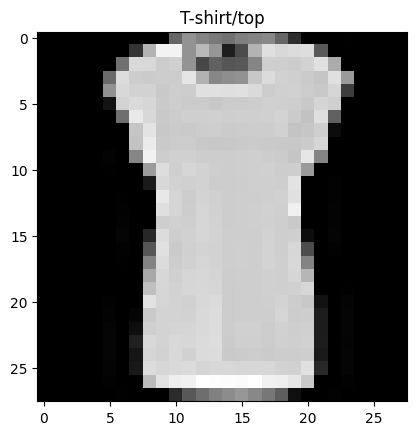

In [50]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]]);

In [51]:
with torch.inference_mode():
    y_preds = []
    for sample in test_samples:
        y_logit = model_2(sample.unsqueeze(dim=0))
        y_prob = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=0)
        y_preds.append(y_prob)
torch.stack(y_preds), test_labels

(tensor([0, 6, 7, 6, 7, 0, 0, 0, 1]), [0, 6, 7, 6, 7, 0, 0, 3, 1])

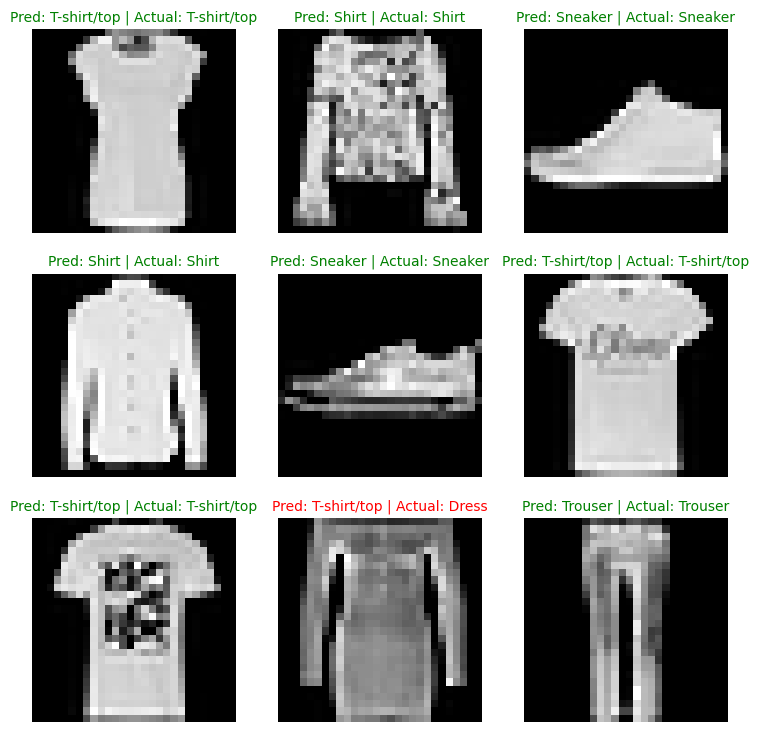

In [52]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i, sample in enumerate(test_samples):
    plt.subplot(rows, cols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[y_preds[i]]
    actual_label = class_names[test_labels[i]]
    title = f"Pred: {pred_label} | Actual: {actual_label}"
    if pred_label == actual_label:
        plt.title(title, fontsize=10, c="g")
    else:
        plt.title(title, fontsize=10, c="r")
    plt.axis(False);

It's also possible to make a confusion matrix, which is conveniently built into PyTorch's torchmetrics library as well. To have this confusion matrix accurately represent the data, predictions will first be made on the entire testing dataset. An additional small library as mlxtend can also be used to plot said confusion matrix.

https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html<br>
https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix

In [53]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    # As the dataloader contains batches, it's not necessary to unsqueeze an additional dimension
    for X, y in test_dataloader:
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred)
        
y_preds_tensor = torch.cat(y_preds)

In [54]:
# Result has the same length as the testing data
len(y_preds_tensor), len(test_data)

(10000, 10000)

In [55]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [56]:
# Creation of the confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds_tensor, target=test_data.targets)

In [57]:
confmat_tensor

tensor([[611,   6,  42,  85,   9,   0, 240,   0,   7,   0],
        [  7, 900,  10,  62,  10,   1,   6,   1,   3,   0],
        [  7,   3, 793,  15, 105,   0,  72,   0,   5,   0],
        [ 27,  11,  24, 854,  40,   0,  35,   0,   7,   2],
        [  5,   4, 105,  53, 721,   0, 108,   0,   4,   0],
        [  8,   2,   7,   5,   0, 844,   4,  52,  57,  21],
        [ 74,   8, 110,  72,  81,   0, 647,   0,   8,   0],
        [  1,   1,   0,   0,   0,  36,   0, 892,  15,  55],
        [ 13,   3,  10,  14,   8,   9,  40,  10, 892,   1],
        [  0,   0,   3,   4,   0,  32,   5,  99,  12, 845]])

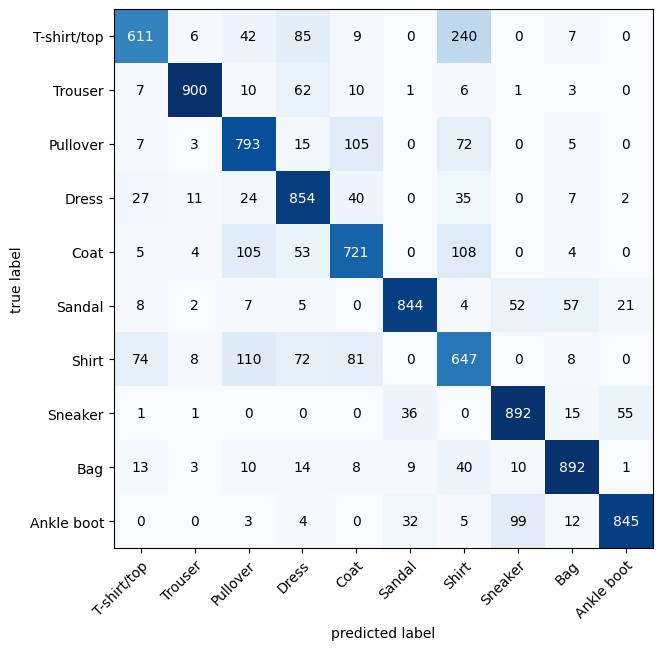

In [58]:
# Using mlxtend and matplotlib to visualize the confmat_tensor as a proper confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # conversion to numpy is needed here
    class_names=class_names,
    figsize=(10,7)
)

## Saving and Loading <a name="saveload" />

The saving and loading models will once again utilize several functions that were used before. These are:
- `torch.save()`: Save a PyTorch object in Python's pickle format
- `torch.load()`: Load a saved PyTorch object
- `torch.nn.Module.load_state_dict()`: Load a model's saved state dictionary

https://pytorch.org/tutorials/beginner/saving_loading_models

In [59]:
# Saving the model in the local /models folder
MODEL_PATH = "models"
MODEL_NAME = "03_pytorch_computer_vision_modelv2.pth"
MODEL_SAVE_PATH = f"{MODEL_PATH}/{MODEL_NAME}"
#torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

In [60]:
# Instantiate new instance of the FashionV2() class
# Load the state_dict of the saved model into the new instance
loaded_model_2 = FashionV2(
    in_shape=1,
    hidden_units=10,
    out_shape=len(class_names)
)
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [61]:
loaded_model_2

FashionV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [62]:
# The results are the same!
loaded_model_2_results = eval_model(loaded_model_2, test_dataloader, loss_fn, metric_acc)
model_2_results, loaded_model_2_results

({'model_name': 'FashionV2',
  'model_loss': tensor(0.3238),
  'model_acc': tensor(0.8813)},
 {'model_name': 'FashionV2',
  'model_loss': tensor(0.3238),
  'model_acc': tensor(0.8813)})

It's also possible to use `torch.isclose()` to see if tensors are "close" to each other. See the docs for more specifics on how this works: https://pytorch.org/docs/stable/generated/torch.isclose

In [63]:
# The results are close to each other (the same)!
torch.isclose(model_2_results["model_loss"], loaded_model_2_results["model_loss"])

tensor(True)